# 1 Loading the tests results
To start with, we download the breton test results.
1. load the api key and connect to the client
2. Find the tests collection and subcollection with a recursive function
3. Convert the documents in one big dictionary
4. Load the dictionary as a json file

In [3]:
%pip install --quiet firebase-admin google-cloud-firestore


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from typing import Dict, Any, List
import firebase_admin  # Import the module directly
from firebase_admin import credentials, initialize_app
from google.cloud import firestore
import json
from datetime import datetime

# 1) Make sure the env var is set:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = (
    "/Users/alan/Repos/analeksis/firebase-admin-key.json"
)

# 2) Initialize Admin SDK (safe to call once)
if not firebase_admin._apps:  # Check if any Firebase apps are initialized
    cred = credentials.ApplicationDefault()
    initialize_app(cred)

# 3) Firestore client
db = firestore.Client()  # Uses GOOGLE_APPLICATION_CREDENTIALS


def _convert_firestore_types(value):
    """
    Convert Firestore-specific types (Timestamp, DocumentReference, GeoPoint) to JSON-serializable forms.
    """
    from google.cloud.firestore_v1 import DocumentReference
    from google.cloud.firestore_v1._helpers import GeoPoint
    from google.protobuf.timestamp_pb2 import Timestamp as PbTimestamp

    # Firestore Timestamp comes in as 'datetime' when using google-cloud-firestore
    import datetime as _dt

    if isinstance(value, _dt.datetime):
        # ISO 8601 string
        return value.isoformat()
    if isinstance(value, DocumentReference):
        return {"__type__": "DocumentReference", "path": value.path}
    if isinstance(value, GeoPoint):
        return {
            "__type__": "GeoPoint",
            "latitude": value.latitude,
            "longitude": value.longitude,
        }
    if isinstance(value, (list, tuple)):
        return [_convert_firestore_types(v) for v in value]
    if isinstance(value, dict):
        return {k: _convert_firestore_types(v) for k, v in value.items()}
    return value


def doc_to_dict(doc_ref: firestore.DocumentReference) -> Dict[str, Any]:
    """
    Return a JSON-serializable dict for a document, including nested subcollections.
    Shape:
    {
        "id": "<doc_id>",
        "data": {...},
        "subcollections": {
            "<subcol_name>": [ {doc...}, ... ],
            ...
        }
    }
    """
    snap = doc_ref.get()
    data = snap.to_dict() or {}
    data = _convert_firestore_types(data)

    # Recurse into subcollections
    sub_map: Dict[str, List[Dict[str, Any]]] = {}
    for subcol in doc_ref.collections():
        docs_list = []
        for subdoc in subcol.stream():
            docs_list.append(doc_to_dict(subdoc.reference))
        sub_map[subcol.id] = docs_list

    return {"id": doc_ref.id, "data": data, "subcollections": sub_map}


# --- Export only "tests" collection ---
def export_tests_collection(limit=None):
    export = []
    col = db.collection("tests")
    count = 0
    for doc in col.stream():
        export.append(doc_to_dict(doc.reference))
        count += 1
        if limit and count >= limit:
            break
    return export


# ---- Run the export ----
export_dict = export_tests_collection()  # pass limit=NN for quick tests

# Write to a timestamped JSON file
outfile = f"all_tests_export_{datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')}.json"
with open(outfile, "w", encoding="utf-8") as f:
    json.dump(export_dict, f, ensure_ascii=False, indent=2)

outfile

/var/folders/f2/5mnmp0cs0bv_h2fdx27y8w580000gn/T/ipykernel_4233/618359319.py:97: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  outfile = f"all_tests_export_{datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')}.json"


'all_tests_export_20250910T155348Z.json'

# 2 Statistical Overview
Before starting the analysis proper, we load the interresting data in a padas dataframe.

In [15]:
import numpy as np
import pandas as pd
import json

# load the json file with all the tests
with open("all_tests.json", "r", encoding="utf-8") as f:
    all_tests = json.load(f)

# create a dataframe to store all the tests sessions results
df = pd.DataFrame(
    columns=["session_id", "test_id", "final_score", "real_words_ratings", "results", "prediction", "square_diff", "brier_score"]
)


df = pd.DataFrame(
    [
        {
            "session_id": session["id"],
            "test_id": test["id"],
            "final_score": session["data"].get("finalRating"),
            "real_words_ratings": [
                item["item"]["r"]
                for item in session["data"]["answeredItems"]
                if item["item"]["isItemRealWord"]
            ],
            "results": [
                item["isAnswerCorrect"]
                for item in session["data"]["answeredItems"]
                if item["item"]["isItemRealWord"]
            ],
            "prediction": [
                1
                / (
                    1
                    + 10
                    ** ((item["item"]["r"] - session["data"].get("finalRating")) / 400)
                )
                for item in session["data"]["answeredItems"]
                if item["item"]["isItemRealWord"]
            ],
            "square_diff": [
                (
                    1
                    / (
                        1
                        + 10
                        ** (
                            (item["item"]["r"] - session["data"].get("finalRating"))
                            / 400
                        )
                    )
                    - int(item["isAnswerCorrect"] == True)
                )
                ** 2
                for item in session["data"]["answeredItems"]
                if item["item"]["isItemRealWord"]
            ],
            "brier_score": np.mean(
                [
                    (
                        1
                        / (
                            1
                            + 10
                            ** (
                                (item["item"]["r"] - session["data"].get("finalRating"))
                                / 400
                            )
                        )
                        - int(item["isAnswerCorrect"] == True)
                    )
                    ** 2
                    for item in session["data"]["answeredItems"]
                    if item["item"]["isItemRealWord"]
                ]
            ),
        }
        for test in all_tests
        if test["data"].get("isActive") is not False
        for session in test["subcollections"].get("test_sessions", [])
    ]
)

df.head(100)

/Users/alan/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/alan/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,session_id,test_id,final_score,real_words_ratings,results,prediction,square_diff,brier_score
0,0QFDVu5fUdLPJxVa3nrb,br,367,"[62, 65, 103, 152, 206, 237, 278, 315, 279, 31...","[True, True, True, True, True, True, True, Fal...","[0.8526729520561114, 0.8504903015468027, 0.820...","[0.021705259055860855, 0.022353149931565983, 0...",0.316223
1,142yFm2vIBrMoAt35DeL,br,823,"[781, 801, 780, 799, 782, 798, 819, 837, 856, ...","[True, True, True, True, True, True, True, Tru...","[0.5601501452319029, 0.5316182978281073, 0.561...","[0.19346789473951614, 0.21938141892943958, 0.1...",0.277136
2,2HfKbydiKGzBGqMbezWT,br,721,"[33, 71, 101, 143, 190, 235, 274, 312, 345, 38...","[True, True, True, True, True, True, True, Tru...","[0.9813016819261839, 0.9768355779567848, 0.972...","[0.00034962709878959616, 0.0005365904485961955...",0.165690
3,2W2CUyvdRaFm3XNSuoKa,br,20,"[503, 450, 403, 358, 315, 270, 226, 190, 136, ...","[False, False, False, False, False, False, Fal...","[0.05839412555299908, 0.07760948942937546, 0.0...","[0.0034098738990994202, 0.006023232849488341, ...",0.068753
4,2bysu0iQZxSuC1jeZuNN,br,272,"[66, 150, 156, 175, 176, 210, 211, 229, 268, 3...","[True, True, True, False, True, True, True, Tr...","[0.7659946707664889, 0.6686949563073317, 0.660...","[0.05475849410968394, 0.10976303197620087, 0.1...",0.241741
...,...,...,...,...,...,...,...,...
95,eWckRKOOaoZ5s1gvwdHw,br,521,"[239, 226, 280, 275, 268, 261, 258, 255, 250, ...","[True, True, True, True, True, True, True, Tru...","[0.8352528323139615, 0.8452938106179996, 0.800...","[0.02714162926057168, 0.023934005033099382, 0....",0.139933
96,fVvKHGbb2vuvOsJC1jAG,br,653,"[611, 612, 614, 617, 641, 619, 637, 624, 644, ...","[True, True, True, True, False, True, True, Tr...","[0.5601501452319029, 0.558731369324761, 0.5558...","[0.19346789473951614, 0.1947180044180005, 0.19...",0.251317
97,gDEkad1BUYQO6nHuV7BV,br,626,"[659, 660, 661, 503, 478, 485, 487, 498, 530, ...","[False, True, True, False, False, True, True, ...","[0.45265148195413535, 0.4512256641402582, 0.44...","[0.20489336411527492, 0.3011532716983007, 0.30...",0.295430
98,hzwE2DEB8MOOpmJFg7UZ,br,1074,"[821, 801, 783, 799, 778, 763, 784, 798, 785, ...","[True, True, True, True, False, True, True, Tr...","[0.8109791581199478, 0.8279993802611698, 0.842...","[0.03572887866504369, 0.02958421319054166, 0.0...",0.134712


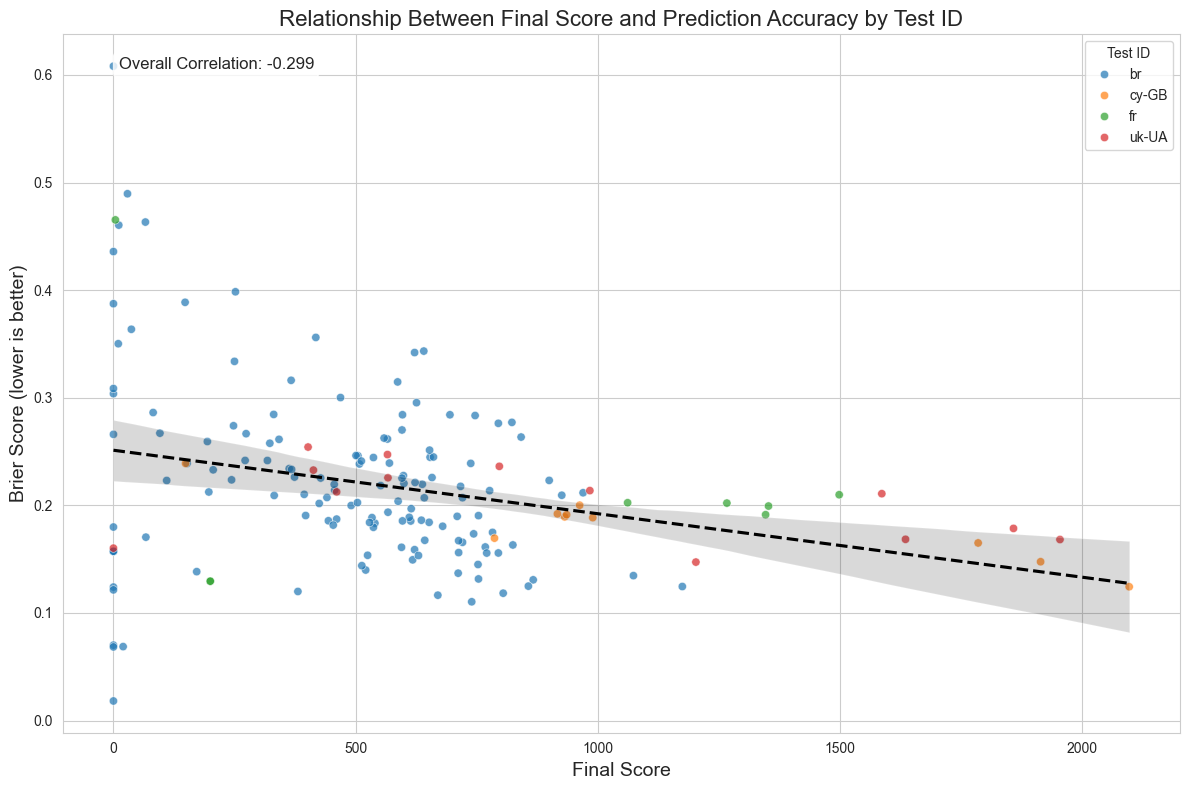

In [17]:
# Create a scatter plot of final_score vs brier_score with colors by test_id
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Create scatter plot with color by test_id
scatter = sns.scatterplot(
    data=df,
    x="final_score",
    y="brier_score",
    hue="test_id",  # Color points by test_id
    alpha=0.7,
    palette="tab10",  # You can choose different color palettes
)

# Add regression line to see overall trend
regression = sns.regplot(
    data=df,
    x="final_score",
    y="brier_score",
    scatter=False,
    line_kws={"color": "black", "linestyle": "--"},
)

# Add labels and title
plt.title(
    "Relationship Between Final Score and Prediction Accuracy by Test ID", fontsize=16
)
plt.xlabel("Final Score", fontsize=14)
plt.ylabel("Brier Score (lower is better)", fontsize=14)

# Add correlation coefficient
correlation = df["final_score"].corr(df["brier_score"])
plt.annotate(
    f"Overall Correlation: {correlation:.3f}",
    xy=(0.05, 0.95),
    xycoords="axes fraction",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8),
)

# Move legend outside the plot if there are many test_ids
if df["test_id"].nunique() > 5:
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Test ID")
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for legend
else:
    plt.legend(title="Test ID")
    plt.tight_layout()

plt.show()


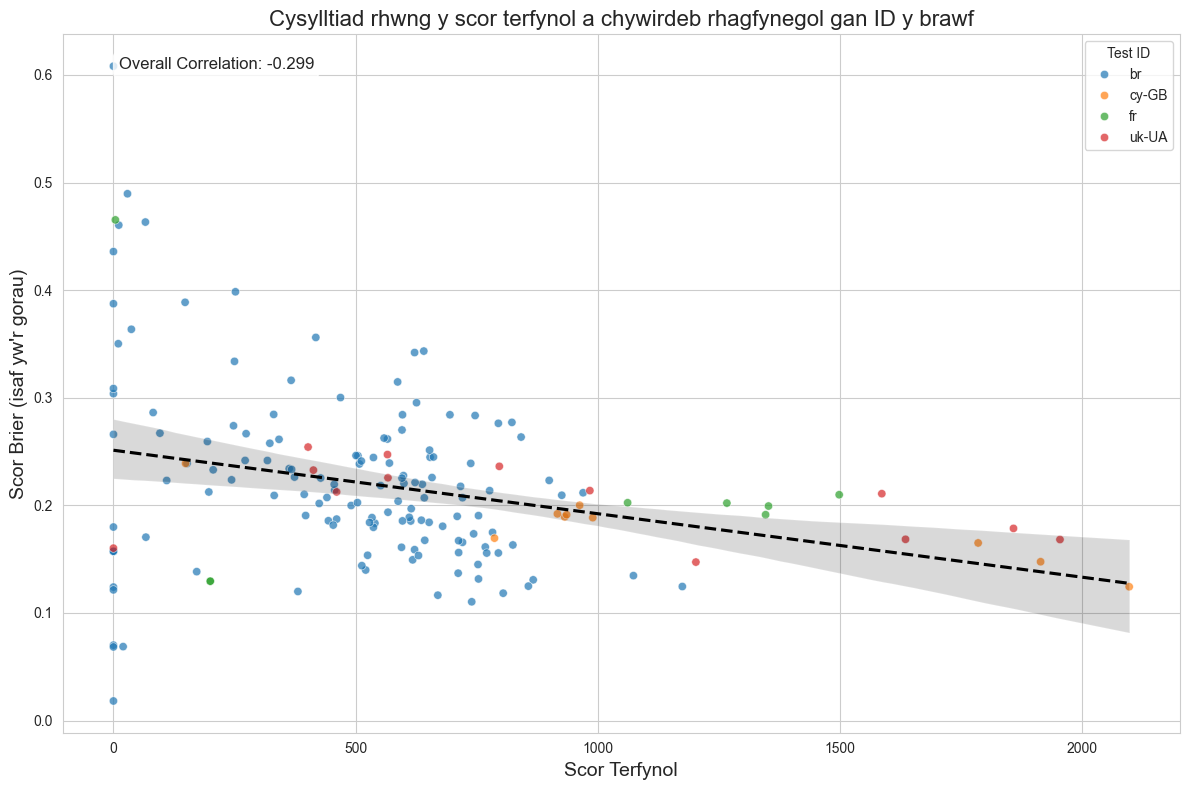

In [ ]:
# Create a scatter plot of final_score vs brier_score with colors by test_id
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Create scatter plot with color by test_id
scatter = sns.scatterplot(
    data=df,
    x="final_score",
    y="brier_score",
    hue="test_id",  # Color points by test_id
    alpha=0.7,
    palette="tab10",  # You can choose different color palettes
)

# Add regression line to see overall trend
regression = sns.regplot(
    data=df,
    x="final_score",
    y="brier_score",
    scatter=False,
    line_kws={"color": "black", "linestyle": "--"},
)

# Add labels and title
plt.title(
    "Cysylltiad rhwng y scor terfynol a chywirdeb rhagfynegol gan ID y brawf", fontsize=16
)
plt.xlabel("Scor Terfynol", fontsize=14)
plt.ylabel("Scor Brier (isaf yw'r gorau)", fontsize=14)

# Add correlation coefficient
correlation = df["final_score"].corr(df["brier_score"])
plt.annotate(
    f"Cysylltiad Cyffredinol: {correlation:.3f}",
    xy=(0.05, 0.95),
    xycoords="axes fraction",
    fontsize=12,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8),
)

# Move legend outside the plot if there are many test_ids
if df["test_id"].nunique() > 5:
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Test ID")
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for legend
else:
    plt.legend(title="ID y Profion")
    plt.tight_layout()

plt.show()